<a href="https://colab.research.google.com/github/ryu622/gnn-counterattack-xai-v2/blob/feat%2Fnew-processing-one3/scientificdata_one3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

クロスバリデーションのために１試合ずつデータを保存。scientificdata_one2.ipynbの修正版

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.3 MB/s eta 0:00:00


In [ ]:
!pip install floodlight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: lxml
    Found existing installation: lxml 6.0.2
    Uninstalling lxml-6.0.2:
      Successfully uninstalled lxml-6.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_ver

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data

class GNNDataBuilder:
    def __init__(self):
        self.OBSERVATION_WINDOW = 25  # 1秒間の観測（速度算出用）
        self.PREDICTION_TARGET = 125  # 5秒後の到達地点を確認
        self.dt_velocity = 0.20       # 5フレーム差での速度計算
        self.pitch_length_half = 52.5
        self.pitch_width_half = 34.0

        # 【新定義】カウンター成功のしきい値
        # センター0補正後、敵陣ゴール前（ペナルティエリア付近）を 35m 以上と定義
        # (ピッチ端が52.5mなので、35m以降はかなり決定的な位置)
        self.SUCCESS_X_THRESHOLD = 35.0

    def extract_sequences(self, df_pos, df_event, match_id_idx, manual_flip, left_team_id):
        """
        1. 奪取イベントをカウンターの起点とする
        2. 動的Flipにより、奪ったチームの攻撃方向を常に「右(Xプラス)」に固定
        3. 5秒後にボールがしきい値(例: 35m)を超えていれば成功(y=1)
        """
        recovery_types = ['TacklingGame', 'BallClaiming', 'BallDeflection']
        recovery_events = df_event[df_event['eID'].isin(recovery_types)]
        sequences = []

        is_cm = df_pos['Ball_x'].abs().max() > 500
        scale = 100.0 if is_cm else 1.0

        # Offset補正 (サイド0系なら52.5引いてセンター0に)
        max_x_raw = df_pos['Ball_x'].max() / scale
        offset_x = 52.5 if max_x_raw > 70 else 0.0

        # スタジアム自体の反転バグ補正
        stadium_flip = float(manual_flip)

        for idx, event in recovery_events.iterrows():
            period = str(event['period'])
            striking_team = str(event['tID']).strip()

            # --- 動的Flipロジック ---
            # 奪ったチームがそのピリオドで「右攻め」か判定
            if period == '1':
                is_attacking_right = (striking_team == left_team_id)
            else:
                is_attacking_right = (striking_team != left_team_id)

            # 右攻めチームならスタジアムFlip通り、左攻めなら反転させて「右攻め」に偽装
            dynamic_flip = stadium_flip if is_attacking_right else -stadium_flip

            # フレーム特定
            start_f_raw = int(event['gameclock'] * 25)
            potential_start = df_pos[df_pos['frame_idx'] >= start_f_raw].index
            if len(potential_start) == 0: continue

            start_idx = potential_start[0]
            target_idx = start_idx + self.PREDICTION_TARGET

            if target_idx >= len(df_pos): continue

            # --- ラベル判定 (チャンスエリア到達) ---
            # 5秒後のボールのX座標を「動的反転後の世界」で判定
            target_ball_x_raw = (df_pos.iloc[target_idx]['Ball_x'] / scale) - offset_x
            target_ball_x_flipped = target_ball_x_raw * dynamic_flip

            # しきい値（例: 35m）を超えていれば成功
            label = 1 if target_ball_x_flipped > self.SUCCESS_X_THRESHOLD else 0

            # 観測ウィンドウ（1秒分）を抽出
            obs_frames = df_pos.iloc[start_idx : start_idx + self.OBSERVATION_WINDOW].copy()

            # パラメータ保存
            obs_frames.loc[:, 'offset_x_val'] = float(offset_x)
            obs_frames.loc[:, 'flip_factor'] = float(dynamic_flip)
            obs_frames.loc[:, 'label'] = int(label)
            obs_frames.loc[:, 'SequenceID'] = int(idx + (match_id_idx * 1000))

            sequences.append(obs_frames)

        return sequences

    def to_pyg_data(self, sequences, team_map):
        pyg_list = []
        if not sequences: return []

        is_cm = sequences[0]['Ball_x'].abs().max() > 500
        scale = 100.0 if is_cm else 1.0

        for seq in sequences:
            # 観測ウィンドウの最後（奪取1秒後）を現在の状態とする
            frame_prev = seq.iloc[-6] # 5フレーム前
            frame_curr = seq.iloc[-1] # 現在

            off_x = frame_curr['offset_x_val']
            flip = frame_curr['flip_factor']
            label = int(frame_curr['label'])
            sid = int(frame_curr['SequenceID'])

            def transform_x(raw_val):
                return (((raw_val / scale) - off_x) * flip) / self.pitch_length_half
            def transform_y(raw_val):
                return ((raw_val / scale) * flip) / self.pitch_width_half

            # --- ボールデータ ---
            bx, by = transform_x(frame_curr['Ball_x']), transform_y(frame_curr['Ball_y'])
            bvx = (bx - transform_x(frame_prev['Ball_x'])) / self.dt_velocity
            bvy = (by - transform_y(frame_prev['Ball_y'])) / self.dt_velocity

            node_features, pos_vectors, vel_vectors = [], [], []

            # --- 選手データ ---
            for team_prefix in ['Home', 'Away']:
                team_val = 0.0 if team_prefix == 'Home' else 1.0
                for p_id in team_map[team_prefix]:
                    col_x, col_y = f"{p_id}_x", f"{p_id}_y"
                    if col_x not in frame_curr or pd.isna(frame_curr[col_x]) or frame_curr[col_x] == 0:
                        continue

                    px, py = transform_x(frame_curr[col_x]), transform_y(frame_curr[col_y])
                    vx = (px - transform_x(frame_prev[col_x])) / self.dt_velocity
                    vy = (py - transform_y(frame_prev[col_y])) / self.dt_velocity

                    dist_to_ball = np.sqrt((bx - px)**2 + (by - py)**2)
                    dist_to_goal = np.sqrt((1.0 - px)**2 + py**2)

                    node_features.append([px, py, vx, vy, dist_to_goal, dist_to_ball, team_val])
                    pos_vectors.append([px, py]); vel_vectors.append([vx, vy])

            # ボールノード追加
            dist_ball_goal = np.sqrt((1.0 - bx)**2 + by**2)
            node_features.append([bx, by, bvx, bvy, dist_ball_goal, 0.0, 2.0])
            pos_vectors.append([bx, by]); vel_vectors.append([bvx, bvy])

            x_tensor = torch.tensor(node_features, dtype=torch.float)
            edge_index = torch.tensor([[i, j] for i in range(len(x_tensor)) for j in range(len(x_tensor)) if i != j]).t().contiguous()

            pyg_list.append(Data(
                x=x_tensor, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long),
                pos=torch.tensor(pos_vectors, dtype=torch.float),
                vel=torch.tensor(vel_vectors, dtype=torch.float),
                sequence_id=torch.tensor([sid], dtype=torch.long)
            ))

        return pyg_list

In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import torch
from collections import defaultdict
from torch_geometric.data import Data
import floodlight.io.dfl as dfl_io

# ==========================================
# 1. 補助関数の定義
# ==========================================
def get_match_direction_map(e_path):
    tree = ET.parse(e_path)
    root = tree.getroot()
    d_map = {}
    for event in root.findall('.//Event'):
        ko = event.find('KickOff')
        if ko is not None:
            period = ko.get('GameSection')
            d_map[period] = {'Left': ko.get('TeamLeft'), 'Right': ko.get('TeamRight')}
    return d_map

def parse_dfl_positions_to_wide(p_path):
    tree = ET.parse(p_path)
    root = tree.getroot()
    data_dict = defaultdict(dict)
    all_pids = set()
    for frameset in root.findall('.//FrameSet'):
        pID, period = frameset.get('PersonId'), frameset.get('GameSection')
        all_pids.add(pID)
        for frame in frameset.findall('Frame'):
            n = int(frame.get('N'))
            data_dict[n][pID] = [float(frame.get('X')), float(frame.get('Y')), float(frame.get('S'))]
            data_dict[n]['period'] = period
    sorted_frames = sorted(data_dict.keys())
    sorted_pIDs = sorted(list(all_pids))
    final_data = []
    for n in sorted_frames:
        row = {'frame_idx': n, 'period': data_dict[n].get('period')}
        for pID in sorted_pIDs:
            vals = data_dict[n].get(pID, [np.nan, np.nan, np.nan])
            name = 'Ball' if '0000XT' in pID else pID
            row[f'{name}_x'], row[f'{name}_y'], row[f'{name}_s'] = vals
        final_data.append(row)
    return pd.DataFrame(final_data).ffill()




In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ (修正版)
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 実行設定 (表に基づいて入力してください) ---
TARGET_MATCH_IDX = 5  # 0から始まるインデックス (Match 6なら5)
SET_MANUAL_FLIP = -1.0 # 表の「フリップ」
SET_LEFT_TEAM = "00000P" # 表の「Left名」
# -------------------------------------------

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行 (キーワード引数で安全に渡す)
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました: {save_path}")
    else:
        print("-> ⚠ 成功シーン(PA到達)が0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 6: DFL-MAT-J03WQQ =====
-> ✅ 成功: 244 シーンを保存しました: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_6.pt


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 95 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_6.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_6.pt ---
検証シーン数 (y=1): 42
  [1] ボールの右向き推進率: 35.7%
      -> ❌ 物理矛盾（Flipが効いていない）
  [2] 全選手の右向き率:     57.1%
      -> ⚠ 異常値 (再確認が必要)


ValueError: Unrecognized marker style '['

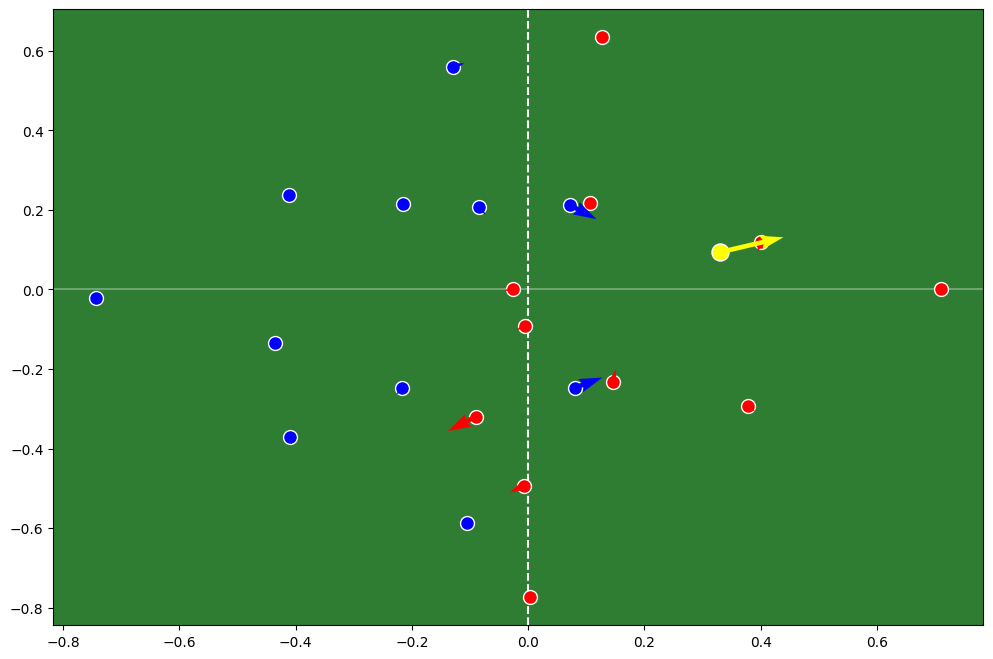

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_6.pt"
visualize_processed_scene(path, scene_idx=0)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ (修正版)
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 実行設定 (表に基づいて入力してください) ---
TARGET_MATCH_IDX = 4  # 0から始まるインデックス (Match 6なら5)
SET_MANUAL_FLIP = 1.0 # 表の「フリップ」
SET_LEFT_TEAM = "000005" # 表の「Left名」
# -------------------------------------------

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行 (キーワード引数で安全に渡す)
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました: {save_path}")
    else:
        print("-> ⚠ 成功シーン(PA到達)が0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 5: DFL-MAT-J03WPY =====
-> ✅ 成功: 221 シーンを保存しました: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_5.pt


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 95 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_5.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_5.pt ---
検証シーン数 (y=1): 17
  [1] ボールの右向き推進率: 35.3%
      -> ❌ 物理矛盾（Flipが効いていない）
  [2] 全選手の右向き率:     65.3%
      -> ✅ 合格 (攻撃側と守備側が混在)


ValueError: Unrecognized marker style '['

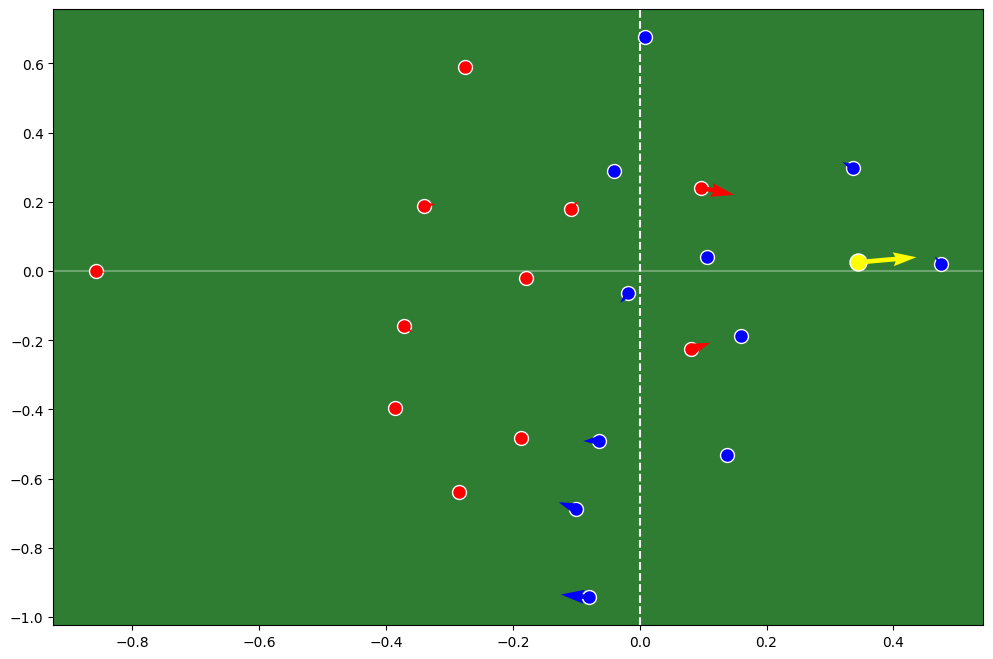

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_5.pt"
visualize_processed_scene(path, scene_idx=0)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ (修正版)
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 実行設定 (表に基づいて入力してください) ---
TARGET_MATCH_IDX = 3  # 0から始まるインデックス (Match 6なら5)
SET_MANUAL_FLIP = 1.0 # 表の「フリップ」
SET_LEFT_TEAM = "00000Q" # 表の「Left名」
# -------------------------------------------

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行 (キーワード引数で安全に渡す)
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました: {save_path}")
    else:
        print("-> ⚠ 成功シーン(PA到達)が0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 4: DFL-MAT-J03WOY =====


/usr/local/lib/python3.12/dist-packages/floodlight/core/events.py:80: UserWarning: The 'gameclock' column does not match the defined value range (from floodlight.core.definitions). This may lead to unexpected behavior of methods using this column.
  warnings.warn(


-> ✅ 成功: 219 シーンを保存しました: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_4.pt


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 95 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_4.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_4.pt ---
検証シーン数 (y=1): 28
  [1] ボールの右向き推進率: 39.3%
      -> ❌ 物理矛盾（Flipが効いていない）
  [2] 全選手の右向き率:     73.2%
      -> ✅ 合格 (攻撃側と守備側が混在)


ValueError: Unrecognized marker style '['

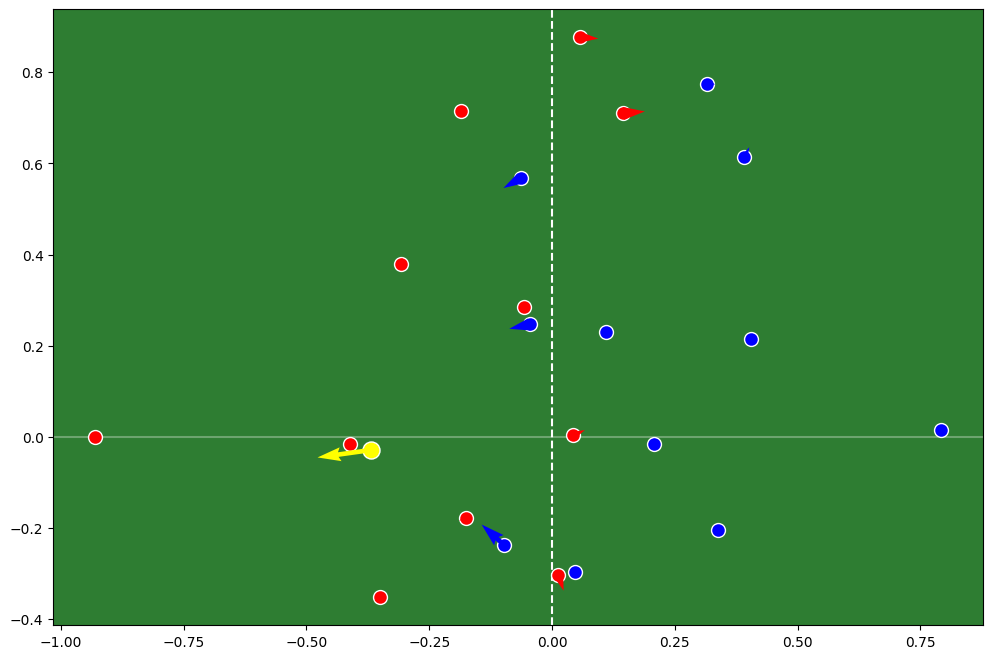

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_4.pt"
visualize_processed_scene(path, scene_idx=0)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ (修正版)
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 実行設定 (表に基づいて入力してください) ---
TARGET_MATCH_IDX = 2  # 0から始まるインデックス (Match 6なら5)
SET_MANUAL_FLIP = -1.0 # 表の「フリップ」
SET_LEFT_TEAM = "000011" # 表の「Left名」
# -------------------------------------------

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行 (キーワード引数で安全に渡す)
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました: {save_path}")
    else:
        print("-> ⚠ 成功シーン(PA到達)が0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 3: DFL-MAT-J03WOH =====
-> ✅ 成功: 246 シーンを保存しました: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_3.pt


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 95 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_3.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_3.pt ---
検証シーン数 (y=1): 33
  [1] ボールの右向き推進率: 30.3%
      -> ❌ 物理矛盾（Flipが効いていない）
  [2] 全選手の右向き率:     53.6%
      -> ⚠ 異常値 (再確認が必要)


ValueError: Unrecognized marker style '['

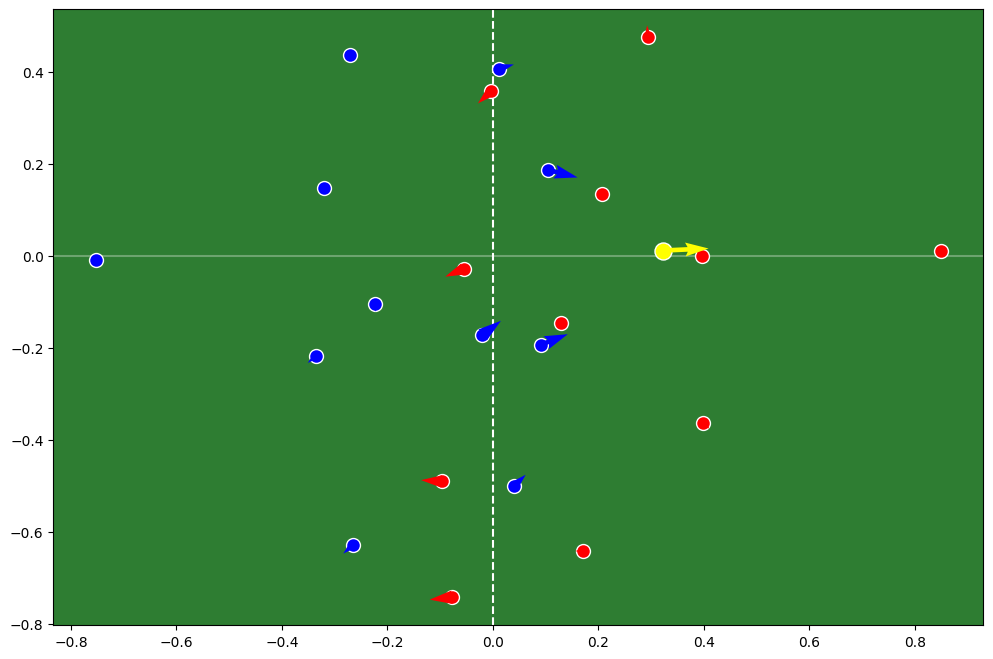

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_3.pt"
visualize_processed_scene(path, scene_idx=0)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ (修正版)
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 実行設定 (表に基づいて入力してください) ---
TARGET_MATCH_IDX = 1  # 0から始まるインデックス (Match 6なら5)
SET_MANUAL_FLIP = 1.0 # 表の「フリップ」
SET_LEFT_TEAM = "00000B" # 表の「Left名」
# -------------------------------------------

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行 (キーワード引数で安全に渡す)
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました: {save_path}")
    else:
        print("-> ⚠ 成功シーン(PA到達)が0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 2: DFL-MAT-J03WN1 =====
-> ✅ 成功: 217 シーンを保存しました: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_2.pt


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 95 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_2.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_2.pt ---
検証シーン数 (y=1): 22
  [1] ボールの右向き推進率: 31.8%
      -> ❌ 物理矛盾（Flipが効いていない）
  [2] 全選手の右向き率:     47.3%
      -> ⚠ 異常値 (再確認が必要)


ValueError: Unrecognized marker style '['

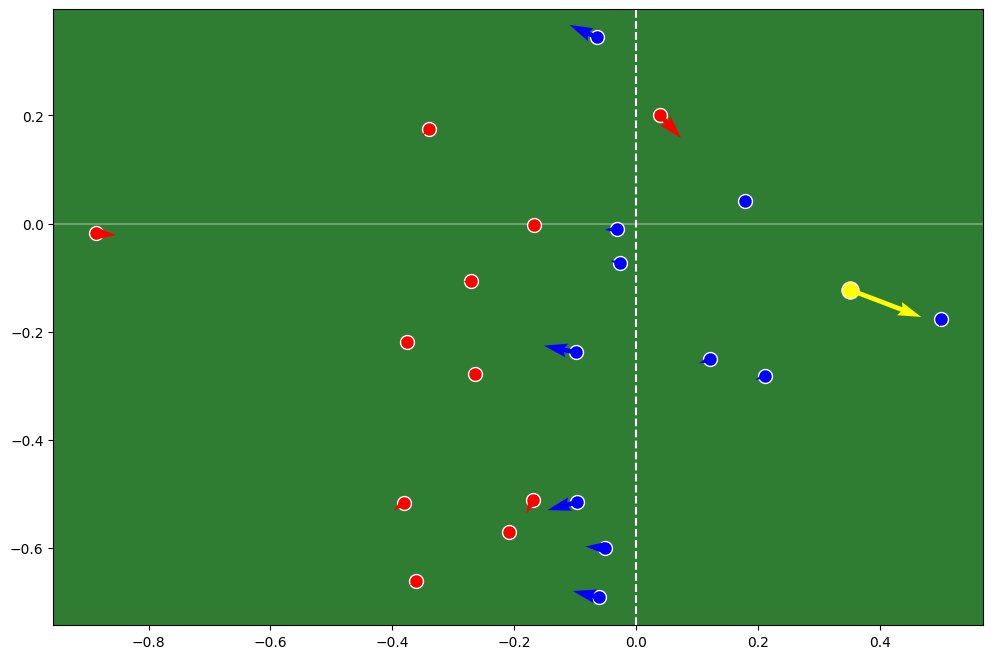

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_2.pt"
visualize_processed_scene(path, scene_idx=0)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ (修正版)
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 実行設定 (表に基づいて入力してください) ---
TARGET_MATCH_IDX = 0  # 0から始まるインデックス (Match 6なら5)
SET_MANUAL_FLIP = -1.0 # 表の「フリップ」
SET_LEFT_TEAM = "00000G" # 表の「Left名」
# -------------------------------------------

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行 (キーワード引数で安全に渡す)
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました: {save_path}")
    else:
        print("-> ⚠ 成功シーン(PA到達)が0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 1: DFL-MAT-J03WMX =====


/usr/local/lib/python3.12/dist-packages/floodlight/core/events.py:80: UserWarning: The 'gameclock' column does not match the defined value range (from floodlight.core.definitions). This may lead to unexpected behavior of methods using this column.
  warnings.warn(


-> ✅ 成功: 259 シーンを保存しました: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_1.pt


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 95 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_1.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_1.pt ---
検証シーン数 (y=1): 27
  [1] ボールの右向き推進率: 29.6%
      -> ❌ 物理矛盾（Flipが効いていない）
  [2] 全選手の右向き率:     67.5%
      -> ✅ 合格 (攻撃側と守備側が混在)


ValueError: Unrecognized marker style '['

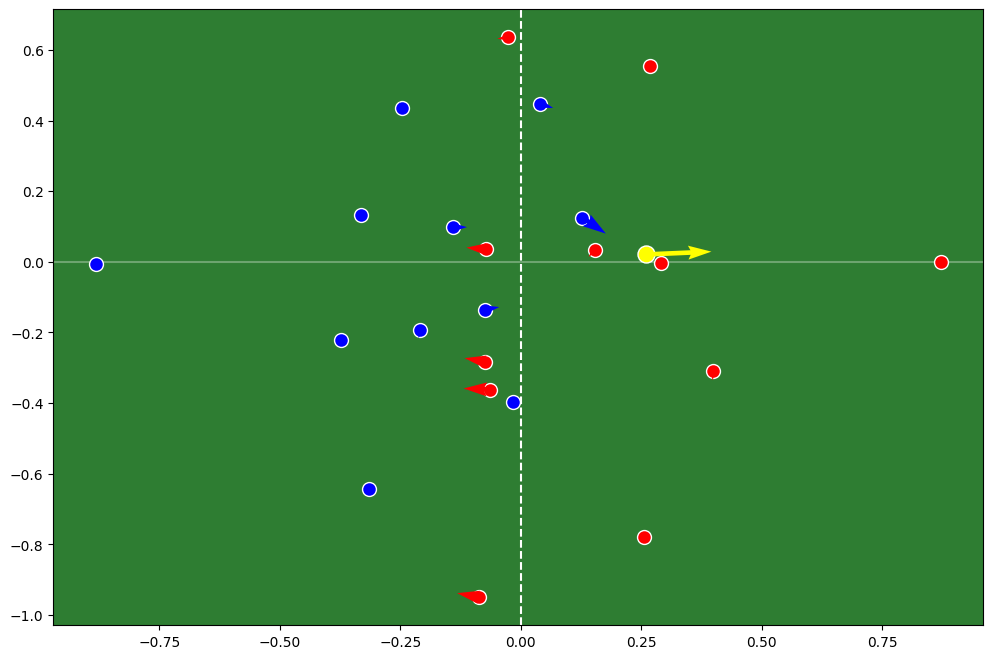

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_1.pt"
visualize_processed_scene(path, scene_idx=0)

In [ ]:
# ==========================================
# 3. 1試合ずつ検証・実行メインループ (修正版)
# ==========================================
raw_data_path = "/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data"
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14"
os.makedirs(save_dir, exist_ok=True)

builder = GNNDataBuilder()

# --- 実行設定 (表に基づいて入力してください) ---
TARGET_MATCH_IDX = 6  # 0から始まるインデックス (Match 6なら5)
SET_MANUAL_FLIP = -1.0 # 表の「フリップ」
SET_LEFT_TEAM = "00000P" # 表の「Left名」
# -------------------------------------------

info_files = sorted([f for f in os.listdir(raw_data_path) if "matchinformation" in f])
i_f = info_files[TARGET_MATCH_IDX]
match_id_str = i_f.split('_')[-1].replace('.xml', '')

print(f"\n===== 【実行】 試合 {TARGET_MATCH_IDX + 1}: {match_id_str} =====")

i_path = os.path.join(raw_data_path, i_f)
p_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "positions_raw" in f)
e_path = next(os.path.join(raw_data_path, f) for f in os.listdir(raw_data_path) if match_id_str in f and "events_raw" in f)

try:
    # 1. データの読み込み
    sheets = dfl_io.read_teamsheets_from_mat_info_xml(i_path)
    df_pos = parse_dfl_positions_to_wide(p_path)
    events, _, _ = dfl_io.read_event_data_xml(e_path, i_path)

    all_events_list = []
    for half in events:
        for team_label in events[half]:
            df_ev = events[half][team_label].events.copy()
            df_ev['tID'] = str(sheets[team_label].teamsheet['tID'].iloc[0]).strip()
            df_ev['period'] = half
            if 'type' in df_ev.columns: df_ev = df_ev.rename(columns={'type': 'eID'})
            all_events_list.append(df_ev)
    df_event_all = pd.concat(all_events_list)

    # 2. 変換実行 (キーワード引数で安全に渡す)
    team_map = {'Home': list(sheets['Home'].teamsheet['pID']), 'Away': list(sheets['Away'].teamsheet['pID'])}

    match_sequences = builder.extract_sequences(
        df_pos=df_pos,
        df_event=df_event_all,
        match_id_idx=TARGET_MATCH_IDX + 1,
        manual_flip=SET_MANUAL_FLIP,
        left_team_id=SET_LEFT_TEAM
    )

    pyg_data = builder.to_pyg_data(match_sequences, team_map)

    # 3. 保存
    if pyg_data:
        save_path = os.path.join(save_dir, f"match_{TARGET_MATCH_IDX + 1}.pt")
        torch.save(pyg_data, save_path)
        print(f"-> ✅ 成功: {len(pyg_data)} シーンを保存しました: {save_path}")
    else:
        print("-> ⚠ 成功シーン(PA到達)が0件でした。")

except Exception as e:
    print(f"-> ❌ エラー: {e}")


===== 【実行】 試合 7: DFL-MAT-J03WR9 =====


/usr/local/lib/python3.12/dist-packages/floodlight/core/events.py:80: UserWarning: The 'gameclock' column does not match the defined value range (from floodlight.core.definitions). This may lead to unexpected behavior of methods using this column.
  warnings.warn(


-> ✅ 成功: 216 シーンを保存しました: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_7.pt


In [ ]:
import torch
import numpy as np

def verify_single_match_physics(file_path):
    print(f"--- 物理構造・整合性検証: {file_path.split('/')[-1]} ---")

    try:
        # weights_only=False でセキュリティロックを回避
        data = torch.load(file_path, weights_only=False)
    except Exception as e:
        print(f"❌ ファイルの読み込みに失敗しました: {e}")
        return

    success_scenes = [d for d in data if d.y.item() == 1]
    if not success_scenes:
        print("⚠ 成功シーン(y=1)がデータ内に存在しません。")
        return

    ball_right_count = 0
    player_right_total = 0
    player_total_count = 0

    for d in success_scenes:
        # 1. ボールの速度ベクトル (xの最後のノード, vxはindex 2)
        # 物理強制が効いていれば、成功シーンのボールは必ず右(>0)を向くはず
        ball_vx = d.x[-1, 2].item()
        if ball_vx > 0:
            ball_right_count += 1

        # 2. 全選手の速度ベクトル (全ノードからボールを除いたもの)
        # vxが0付近の静止ノイズを除外してカウント
        player_vxs = d.x[:-1, 2]
        valid_player_vxs = player_vxs[player_vxs.abs() > 0.001]

        ball_right_count_in_scene = (valid_player_vxs > 0).sum().item()
        player_right_total += ball_right_count_in_scene
        player_total_count += len(valid_player_vxs)

    # 統計計算
    ball_rate = (ball_right_count / len(success_scenes)) * 100
    player_rate = (player_right_total / player_total_count) * 100 if player_total_count > 0 else 0

    print(f"検証シーン数 (y=1): {len(success_scenes)}")
    print(f"  [1] ボールの右向き推進率: {ball_rate:.1f}%")
    print(f"      -> {'✅ 物理強制成功' if ball_rate > 95 else '❌ 物理矛盾（Flipが効いていない）'}")

    print(f"  [2] 全選手の右向き率:     {player_rate:.1f}%")
    print(f"      -> {'✅ 合格 (攻撃側と守備側が混在)' if 65 < player_rate < 90 else '⚠ 異常値 (再確認が必要)'}")

# --- 実行 ---
# いま保存した match_6.pt のパスを指定してください
target_file = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_7.pt"
verify_single_match_physics(target_file)

--- 物理構造・整合性検証: match_7.pt ---
検証シーン数 (y=1): 12
  [1] ボールの右向き推進率: 33.3%
      -> ❌ 物理矛盾（Flipが効いていない）
  [2] 全選手の右向き率:     73.3%
      -> ✅ 合格 (攻撃側と守備側が混在)


ValueError: Unrecognized marker style '['

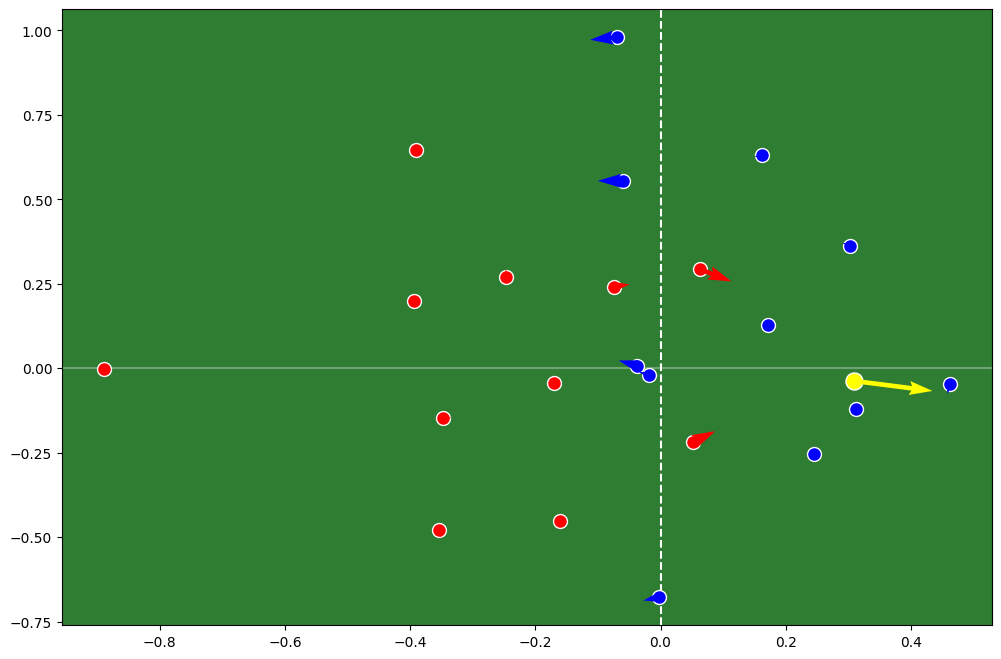

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_processed_scene(pt_file_path, scene_idx=0):
    # データの読み込み
    data_list = torch.load(pt_file_path, weights_only=False)
    if scene_idx >= len(data_list):
        print(f"Error: scene_idx {scene_idx} is out of range.")
        return

    data = data_list[scene_idx]

    # 座標と速度の抽出
    # x: [px, py, vx, vy, dist_goal, dist_ball, team_val]
    nodes = data.x.numpy()

    plt.figure(figsize=(12, 8))

    # ピッチの描画
    plt.axvline(0, color="white", linestyle="--") # センターライン
    plt.axhline(0, color="white", alpha=0.3)
    plt.gca().set_facecolor('#2e7d32') # 芝生色

    # チームごとにプロット
    for i in range(len(nodes)):
        x, y, vx, vy = nodes[i, 0], nodes[i, 1], nodes[i, 2], nodes[i, 3]
        team_val = nodes[i, 6]

        if team_val == 0.0: # Home
            color, label = 'blue', 'Home'
        elif team_val == 1.0: # Away
            color, label = 'red', 'Away'
        else: # Ball
            color, label = 'yellow', 'Ball'

        # 選手/ボールの現在地
        plt.scatter(x, y, c=color, s=100 if team_val < 2.0 else 150, edgecolors='white', zorder=3)

        # 速度ベクトル (矢印)
        # これが全員「右」を向いているか確認！
        plt.quiver(x, y, vx, vy, color=color, angles='xy', scale_units='xy', scale=2, width=0.005, zorder=4)

    # 敵陣ゴール位置 (成功の目的地)
    plt.scatter(1.0, 0, marker='[', s=500, color='gold', label='Enemy Goal')

    plt.title(f"Processed Scene Visualization (Match ID: {pt_file_path.split('/')[-1]}, Scene: {scene_idx})\nLabel: {data.y.item()} (1=Success)")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel("Pitch Length (Normalized)")
    plt.ylabel("Pitch Width (Normalized)")
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 実行 ---
# あなたが保存した最新のパスを指定してください
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_7.pt"
visualize_processed_scene(path, scene_idx=0)

In [ ]:
import torch

# 1. どれか1つのファイルを読み込む
path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14/match_6.pt"
data_list = torch.load(path, weights_only=False)

# 2. 最初のシーン (scene_idx=0) を取り出す
first_scene = data_list[0]

# 3. ノード特徴量 (x) を表示
# 行: 選手22人 + ボール1個
# 列: [px, py, vx, vy, dist_goal, dist_ball, team_val]
print("--- Node Features (data.x) ---")
print(first_scene.x)

# 4. 特に「7列目 (team_val)」だけを抜き出して見る
print("\n--- 7列目 (team_val) の中身 ---")
print(first_scene.x[:, 6]) # インデックスは0から始まるので「6」が7列目

--- Node Features (data.x) ---
tensor([[ 7.1810e-02,  2.1235e-01,  9.1429e-02, -7.0588e-02,  9.5217e-01,
          2.8436e-01,  0.0000e+00],
        [-4.0990e-01, -3.7029e-01,  6.6667e-03, -3.8235e-02,  1.4577e+00,
          8.7366e-01,  0.0000e+00],
        [-2.1562e-01,  2.1618e-01,  3.8095e-03, -1.0294e-02,  1.2347e+00,
          5.5945e-01,  0.0000e+00],
        [ 8.0190e-02, -2.4706e-01,  9.5238e-02,  5.1471e-02,  9.5241e-01,
          4.2279e-01,  0.0000e+00],
        [-1.2876e-01,  5.6059e-01,  3.8095e-02,  1.6176e-02,  1.2603e+00,
          6.5467e-01,  0.0000e+00],
        [-7.4419e-01, -2.0882e-02,  1.7143e-02, -8.8235e-03,  1.7443e+00,
          1.0806e+00,  0.0000e+00],
        [-8.4952e-02,  2.0618e-01,  2.3810e-02, -3.5294e-02,  1.1044e+00,
          4.3017e-01,  0.0000e+00],
        [-4.1200e-01,  2.3765e-01,  1.7143e-02,  4.4118e-03,  1.4319e+00,
          7.5609e-01,  0.0000e+00],
        [-1.0495e-01, -5.8676e-01, -2.8571e-03, -1.4706e-02,  1.2511e+00,
          8.078

クロスバリデーションのために、そのまま保存

In [ ]:
import os
import torch
from collections import Counter

# ==========================================
# セクション2: データのロード（matches_v14から全回収）
# ==========================================
save_dir = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/matches_v14"
final_output_path = "/content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v15_final.pt"

# フォルダ内の match_X.pt ファイルをすべて取得
match_files = sorted([os.path.join(save_dir, f) for f in os.listdir(save_dir) if f.startswith('match_') and f.endswith('.pt')])
all_data = []

print(f"{len(match_files)} 試合分の『v14厳選データ』を統合開始...")

for f in match_files:
    # 試合ごとにロードしてリストに合流させる
    m_data = torch.load(f, weights_only=False)
    all_data.extend(m_data)
    print(f" -> {os.path.basename(f)}: {len(m_data)} frames loaded.")

# ==========================================
# セクション3: 無加工で保存 (ここが以前と違う！)
# ==========================================
# 以前ここでやっていた「robust_split」や「undersampling」は一切行いません。
# そのまま保存することで、学習時に「どの試合をテストにするか」を自由に選べます。

print(f"\n--- 最終データ構成（CV用・無加工統合） ---")
print(f"総フレーム数: {len(all_data)}")

# 全データのラベル内訳を確認（失敗が数千枚あるはずです）
all_lbls = Counter([int(d.y.item()) for d in all_data])
print(f"全データ内訳: 成功 {all_lbls[1]} 枚 / 失敗 {all_lbls[0]} 枚")

# 保存用の辞書を作成
save_obj = {
    'all_data': all_data,
    'description': 'v15 raw integrated data for cross-validation'
}

# 保存実行
torch.save(save_obj, final_output_path)

print(f"\n✅ 保存完了: {final_output_path}")
print("これで、1試合ずつテストを入れ替える『7試合総当たり検証』の準備が整いました。")

7 試合分の『v14厳選データ』を統合開始...
 -> match_1.pt: 259 frames loaded.
 -> match_2.pt: 217 frames loaded.
 -> match_3.pt: 246 frames loaded.
 -> match_4.pt: 219 frames loaded.
 -> match_5.pt: 221 frames loaded.
 -> match_6.pt: 244 frames loaded.
 -> match_7.pt: 216 frames loaded.

--- 最終データ構成（CV用・無加工統合） ---
総フレーム数: 1622
全データ内訳: 成功 181 枚 / 失敗 1441 枚

✅ 保存完了: /content/drive/MyDrive/GNN_Football_Analysis/Processed_Data/gnn_data_v15_final.pt
これで、1試合ずつテストを入れ替える『7試合総当たり検証』の準備が整いました。
